In [5]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [185]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [186]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Logged Out Users Pre and Post  Language Switching Deployment Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**13 Septembter 2021**

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Language Link Clicks](#Language-Link-Clicks)
5. [Input Language Link Clicks](#Input-Language-Link-Clicks)

# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team)  is introducing a new way to switch to a different language wiki. The original language list appears on the sidebar. The new solution replaces the original one by providing 1) a language option button on the top of the page, 2) Selecting the language button will open the list of languages that will contain the suggested languages for each user, as well as a full list of all available languages for that article.
You can find more information on this change and other feature deployments on the [Language switching project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Language_switching).


For the logged-in users, an AB test was performed on the early adopter wikis except fawiki between June 22, 2021 and July 20, 2021. On fawiki, the AB test was performed between June 28 and July 20, 2021. We will share the analysis for the AB test in another report.

For the logged-out users, the new feature was originally planned to enable after AB tes, on July 20, 2021. However it was accidentally enabled on logged-out users together with the AB test, discussed on [T289200](https://phabricator.wikimedia.org/T289200). This report details the analysis and results for the deployment of language switch on logged-out users. 

# Purpose

The goal of the pre-post analysis is to  identify any changes in user behavior that might have resulted from the deployment of the new language feature. Our hypothesis is that more clicks on the new language button and links as it’s easier to discover. 

# Methodology

We reviewed the total number of clicks on language links and input language links separately. We did not review the number of clicks on interface language links because it’s only available for logged-in users not for logged-out users. 

We selected the 7 days before the deployment as the pre deployment period. Due to caching, not all users were seeing the new version immediately after deployment. Therefore, we defined the first 15 days after deployment as the catch-up period and excluded them in the analysis. Post period analysis reviewed the total number of clicks  from 16th day to 23th day after the deployment. 
 
The clicks on input language links within 7 days are too few to show a consistent trend. We also reviewed the average daily clicks for a longer period of time. The pre period extended to as earlier as the data is available ( June 11, 2021). The post period extended to August 31. 2021.



# Language Link Clicks

__New feature -- language link clicks after new button clicks__
<img src="Figures/new_lang_link.png" width="800" height="600" align="center"/>

In [6]:
query_language_clicks_new <- 
"
-- sessions where new lang button was selected
WITH new_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210831')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = true
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    event.isanon,
    wiki
),

lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210831')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon =true
    AND event.action = 'language-change'
    AND event.context='content-language-switcher'
    AND event.skinVersion = 'latest'
)

SELECT
    new_button.button_date,
    lang_switches.switch_date,
    new_button.session_id,
    new_button.wiki,
    new_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    lang_switches.switch_context
FROM new_button
LEFT JOIN lang_switches ON
    new_button.session_id = lang_switches.session_id AND
    new_button.wiki = lang_switches.wiki 
"

In [193]:
#new_language_link_clicks <-  wmfdata::query_hive(query_language_clicks_new)

In [172]:
write_csv(new_language_link_clicks, file = 'Data_logout/new_language_link_clicks.csv')

In [173]:
#new_language_link_clicks <- read_csv('Data_logout/new_language_link_clicks.csv')

In [10]:
new_lang_link_clicks_by_date <- new_language_link_clicks  %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(n_events_new_language_change = n(), .groups = 'drop')

new_lang_link_clicks_by_date$switch_date <- as.Date(new_lang_link_clicks_by_date$switch_date)

__Old feature -- language link clicks on sidebar__

<img src="Figures/old_lang_link.png" width="200" height="120" align="center"/>

In [12]:
query_old_language_link <- 
"
SELECT
    TO_DATE(dt) AS `date`,
    wiki,
    event.web_session_id,
    event.usereditbucket,
    event.timetochangelanguage,
    event.interfacelanguage,
    event.contentlanguage,
    event.selectedinterfacelanguage,
    Count(*) AS n_events
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210601' and '20210628')
    AND event.context = 'languages-list' and event.action = 'language-change' 
    AND event.skinVersion = 'latest' 
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false 
-- only anonymous users
    AND event.isanon =true
GROUP BY
    TO_DATE(dt),
    wiki,
    event.web_session_id,
    event.usereditbucket,
    event.timetochangelanguage,
    event.interfacelanguage,
    event.contentlanguage,
    event.selectedinterfacelanguage
"

In [189]:
#old_lang_link_clicks <-  wmfdata::query_hive(query_old_language_link)

In [174]:
write_csv(old_lang_link_clicks, file = 'Data_logout/old_lang_link_clicks.csv')

In [175]:
#old_lang_link_clicks <- read_csv('Data_logout/old_lang_link_clicks.csv')

In [25]:
old_lang_link_clicks_by_date <- old_lang_link_clicks %>%
    group_by( wiki, date) %>%
    summarize(n_events_language_link = sum(n_events),.groups='drop')

In [27]:
old_lang_link_clicks_by_date$date <- as.Date(old_lang_link_clicks_by_date$date)

__Old feature -- language link clicks after N-more button clicks on sidebar__
<img src="Figures/old_N-more.png" width="400" height="200" align="center"/>

In [15]:
query_n_more_lang_switch <- 
"
-- sessions where N-more lang button was selected
WITH button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210601' and '20210628')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon =true
    AND event.action = 'compact-language-links-open'
    AND event.context = 'other'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.isanon,
    event.context as switch_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210601' and '20210628')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon =true
    AND event.action = 'language-change'
    AND event.context='content-language-switcher'
    AND event.skinVersion = 'latest'
)

SELECT
    button.button_date,
    lang_switches.switch_date,
    button.session_id,
    button.wiki,
    button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(lang_switches.session_id IS NOT NULL AND switch_date >= button_date , 1, 0) AS language_switch,
    lang_switches.switch_context
FROM button
LEFT JOIN lang_switches ON
    button.session_id = lang_switches.session_id AND
    button.wiki = lang_switches.wiki
"

In [190]:
#n_more_lang_clicks <-  wmfdata::query_hive(query_n_more_lang_switch)

In [176]:
write_csv(n_more_lang_clicks, file = 'Data_logout/n_more_switch_lang_clicks.csv')

In [177]:
#n_more_lang_clicks <- read_csv('Data_logout/n_more_switch_lang_clicks.csv')

In [23]:
n_more_lang_clicks_by_date <- n_more_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(n_events_n_more_language_switch = sum(language_switch),.groups='drop')

n_more_lang_clicks_by_date$switch_date <- as.Date(n_more_lang_clicks_by_date$switch_date)

In [28]:
date_seq <- seq(as.Date('2021-06-01'), as.Date('2021-08-31'), by = 'days')

In [29]:
wiki_seq <- c('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')

In [30]:
df_lang_clicks= expand.grid(date=date_seq, wiki=wiki_seq )

In [31]:
df_lang_clicks<-  merge(df_lang_clicks , new_lang_link_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)
df_lang_clicks <-  merge(df_lang_clicks , old_lang_link_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","date"), all.x = TRUE)
df_lang_clicks <-  merge(df_lang_clicks , n_more_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"),  all.x = TRUE)

In [32]:
df_lang_clicks[is.na(df_lang_clicks)] <- 0

In [34]:
df_lang_clicks <- mutate(df_lang_clicks, n_events_old=n_events_language_link+n_events_n_more_language_switch)

In [37]:
df_lang_clicks <- df_lang_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
)

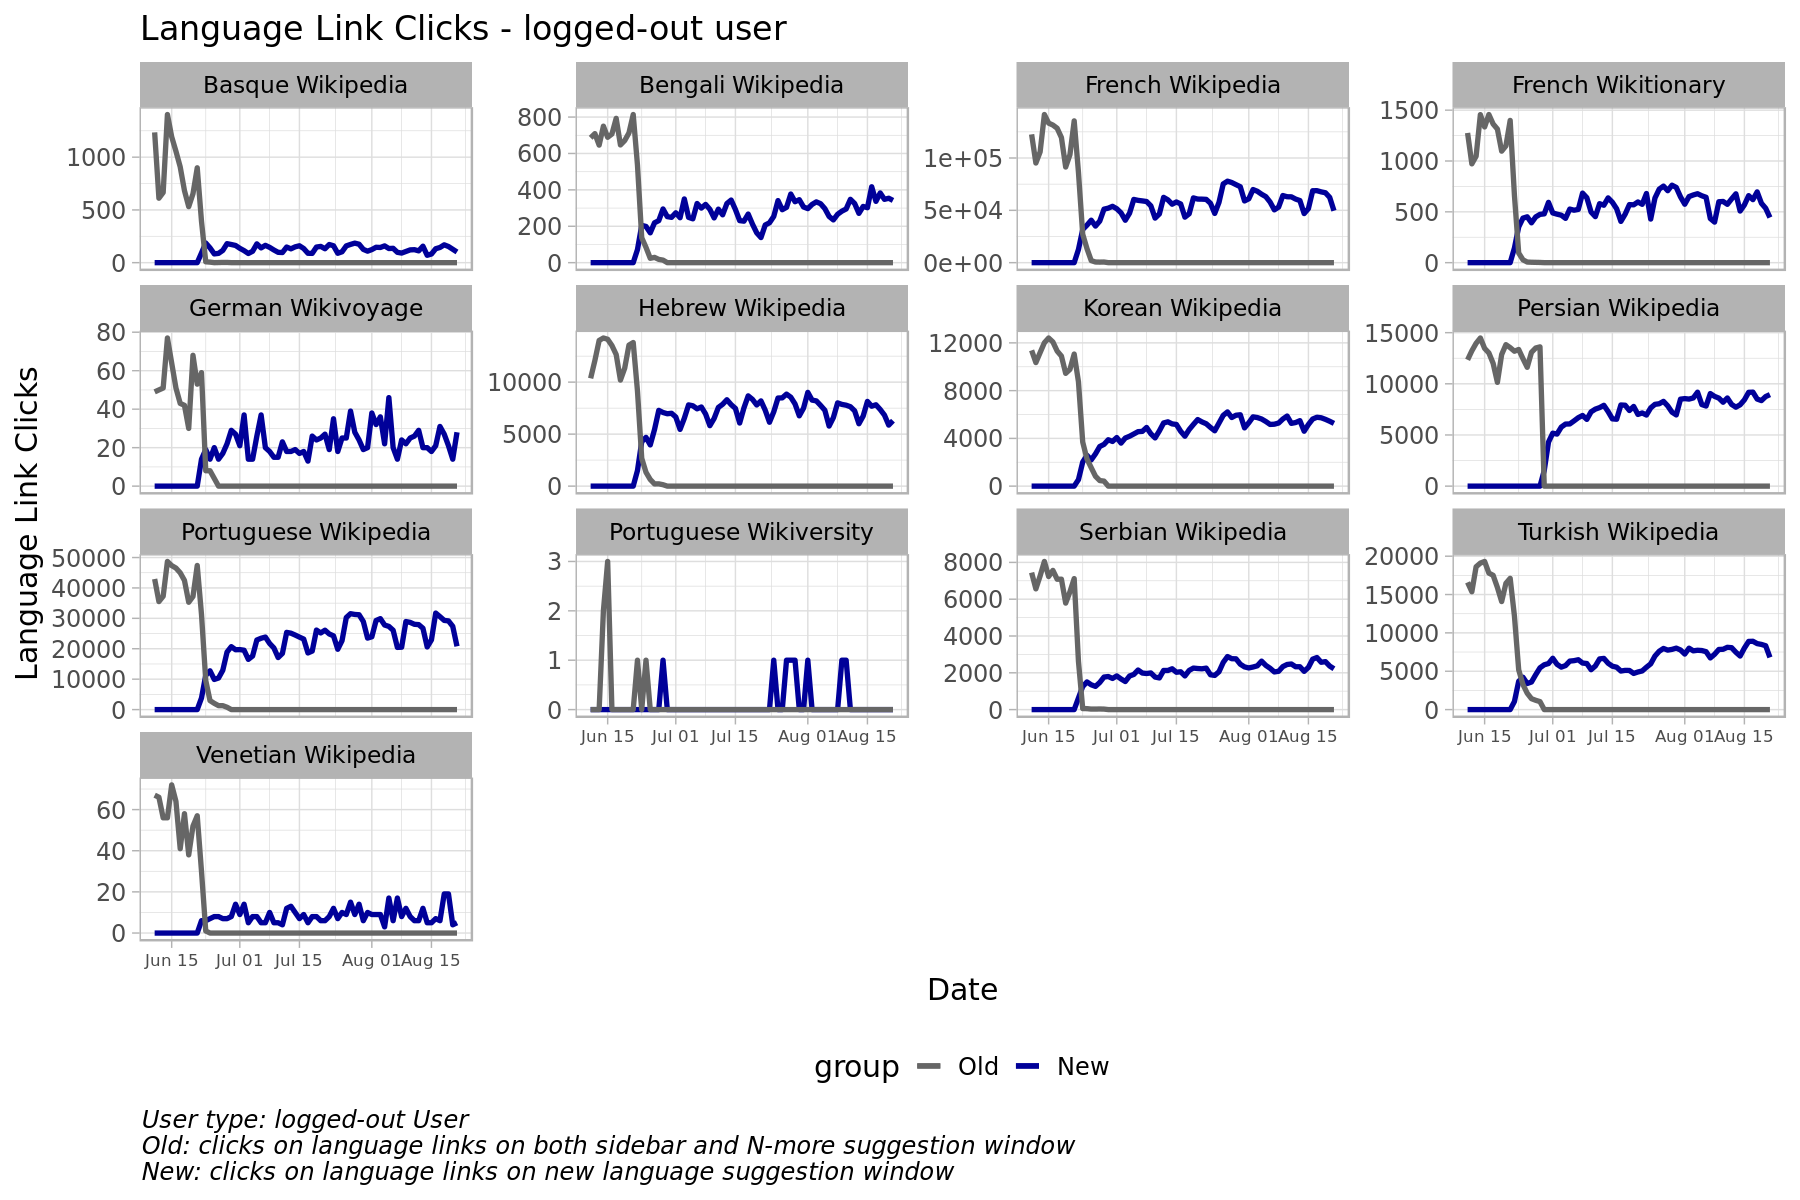

In [169]:
df_lang_clicks_g <- ggplot(data=filter( df_lang_clicks,  (date > '2021-06-10')&(date < '2021-08-22')), 
                                mapping=aes(x=date)) +
geom_line(aes(y=n_events_new_language_change , color="c2") , size = 1.5) +
geom_line(aes(y=n_events_old, color="c1") , size = 1.5) +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
scale_color_manual(values= c("c1"="#666666", "c2"="#000099"), name = "group", labels = c("Old", "New"))  +
labs(title = 'Language Link Clicks - logged-out user',
     x = 'Date',
     y = 'Language Link Clicks',
    caption = "User type: logged-out User
Old: clicks on language links on both sidebar and N-more suggestion window
New: clicks on language links on new language suggestion window"
    ) + 
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
ggsave("Graphs_logout/lang_link_clicks.png",
    plot = df_lang_clicks_g, width = 60, height = 30, units = "cm", dpi = "screen");
df_lang_clicks_g

In [68]:
# add column classifying pre and post deployment dates
df_lang_clicks_prepost <- df_lang_clicks %>%
    mutate(deployment = case_when(
        date >= '2021-06-15' & date <= '2021-06-21' & wiki !='fawiki' ~ 'pre',
        date >= '2021-07-06' & date <= '2021-07-12' & wiki !='fawiki' ~ 'post',
        date >= '2021-06-21' & date <= '2021-06-27' & wiki =='fawiki' ~ 'pre',
        date >= '2021-07-12' & date <= '2021-07-18' & wiki =='fawiki' ~ 'post',        
        TRUE ~ 'NA'
    ))   %>%
    filter(deployment!='NA') %>%
    group_by(wiki_name, deployment) %>%
    summarize(old_lang_link_clicks = sum(n_events_old), new_lang_link_clicks = sum(n_events_new_language_change),  .groups = 'drop')

In [70]:
df_lang_clicks_prepost_long <- pivot_longer(df_lang_clicks_prepost[order(df_lang_clicks_prepost$wiki_name, rev(df_lang_clicks_prepost$deployment)),], cols = c('old_lang_link_clicks','new_lang_link_clicks' ), names_to="group", values_to="lang_link_clicks")

In [72]:
df_lang_clicks_prepost_long$deployment <- factor(df_lang_clicks_prepost_long$deployment,levels = c("pre", "post"))

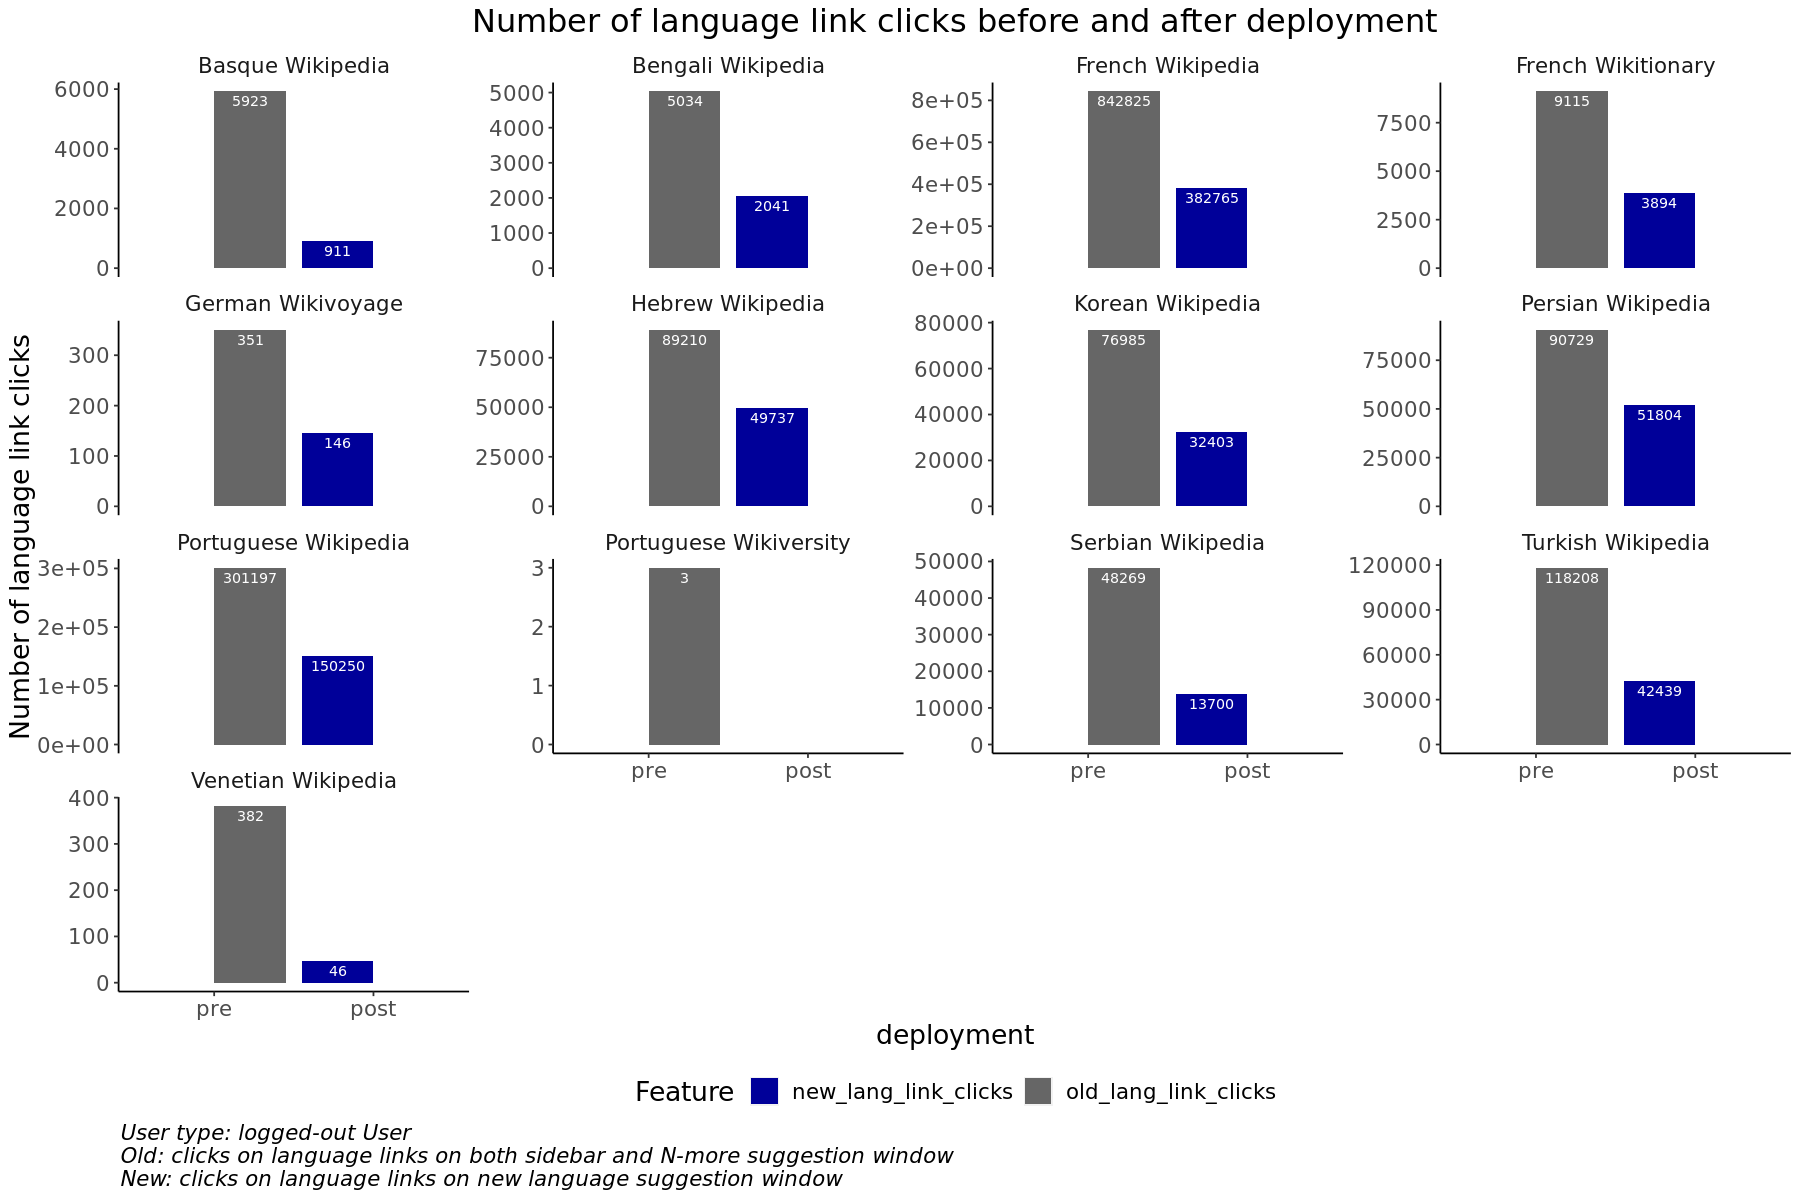

In [164]:
lang_clicks_barchart <- df_lang_clicks_prepost_long %>%
        ggplot(aes(x = deployment, y= lang_link_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(lang_link_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of language link clicks",
             title = "Number of language link clicks before and after deployment",
             caption = "User type: logged-out User
Old: clicks on language links on both sidebar and N-more suggestion window
New: clicks on language links on new language suggestion window") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
lang_clicks_barchart
ggsave("Graphs_logout/lang_link_clicks_bar.png",
    plot = lang_clicks_barchart, width = 60, height = 30, units = "cm", dpi = "screen");

In [83]:
df_lang_clicks_prepost$clicks <- ifelse(df_lang_clicks_prepost$deployment == 'pre', df_lang_clicks_prepost$old_lang_link_clicks, df_lang_clicks_prepost$new_lang_link_clicks)

In [85]:
df_lang_clicks_prepost_w <- df_lang_clicks_prepost %>%
  select(wiki_name, deployment,clicks) %>%
  pivot_wider(names_from = deployment, values_from = clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

In [93]:
df_lang_clicks_prepost_w

wiki_name,post,pre,pct_change
<chr>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,911,5923,-84.62
Bengali Wikipedia,2041,5034,-59.46
French Wikipedia,382765,842825,-54.59
French Wikitionary,3894,9115,-57.28
German Wikivoyage,146,351,-58.40
Hebrew Wikipedia,49737,89210,-44.25
Korean Wikipedia,32403,76985,-57.91
Persian Wikipedia,51804,90729,-42.90
Portuguese Wikipedia,150250,301197,-50.12


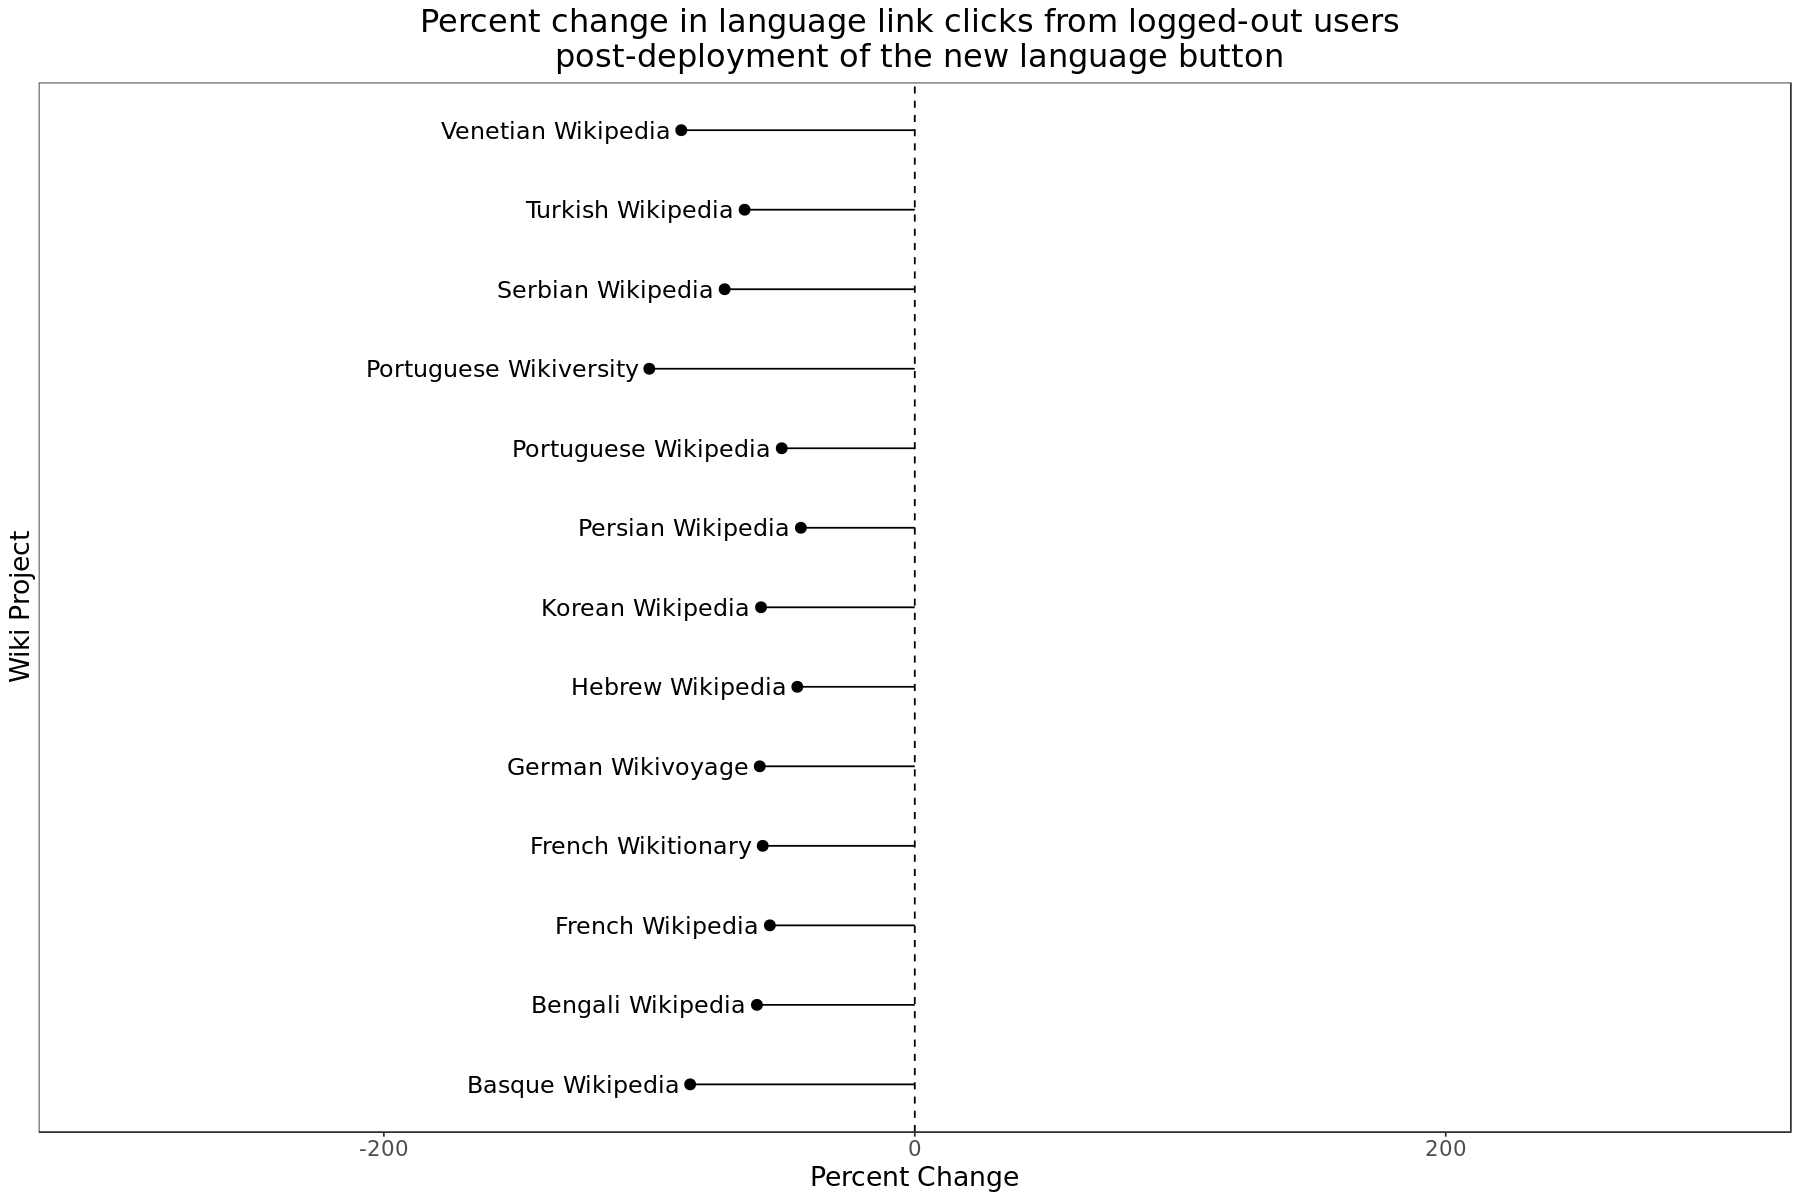

In [92]:
pct_g <- df_lang_clicks_prepost_w %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in language link clicks from logged-out users \n post-deployment of the new language button") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

In [166]:
ggsave("Graphs_logout/lang_link_clicks_pct.png",
    plot = pct_g, width = 60, height = 30, units = "cm", dpi = "screen");

__Average percent change__

In [187]:
mean((filter(df_lang_clicks_prepost_w, wiki_name!='Portuguese Wikiversity'))$pct_change)

[1] -61.10083

__Summary__

There was an average 61.1% decrease[^1] in total clicks on language links by logged-out users on the early adopter wikis following deployment of the new language feature. We saw a similar drop on logged-in users in the AB test. The decrease is contradicted with our hypothesis. It might be due to the lags in new feature adoption. Further investigation may be needed to identify possible reasons for this decrease.

[^1]: Calculated by taking the average of the percent changes observed on each early adopter wiki.

# Input Language Link Clicks

__New feature -- input language link clicks after new button clicks__
<img src="Figures/old_input_lang.png" width="600" height="400" align="center"/>

In [105]:
query_input_language_change_new <- 
"
-- sessions where new lang button was selected
WITH new_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210831')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = true
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

input_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210831')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = true
    AND event.action='ime-change'
    AND event.skinVersion = 'latest'
)

SELECT
    new_button.button_date,
    input_lang_switches.switch_date,
    new_button.session_id,
    new_button.wiki,
    new_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(input_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    input_lang_switches.switch_context
FROM new_button
LEFT JOIN input_lang_switches ON
    new_button.session_id = input_lang_switches.session_id AND
    new_button.wiki = input_lang_switches.wiki
"

In [191]:
#new_input_lang_clicks <-  wmfdata::query_hive(query_input_language_change_new)

In [178]:
write_csv(new_input_lang_clicks, file = 'Data_logout/new_input_lang_clicks.csv')

In [115]:
new_input_lang_clicks_by_date <- new_input_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(new_input_language_clicks = sum(language_switch), .groups='drop')

new_input_lang_clicks$switch_date <- as.Date(new_input_lang_clicks$switch_date, format = "%Y-%m-%d")

__Old feature -- input langauage link clicks after setting button clicks on sidebar__
<img src="Figures/new_input_lang.png" width="600" height="400" align="center"/>

In [116]:
query_input_language_old <- 
"
-- sessions where setting button was selected
WITH setting_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210601' and '20210628')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = true
    AND event.action = 'settings-open'
    AND event.context = 'interlanguage'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

input_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event.universallanguageselector
WHERE
    year = 2021 and month in (6,7) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210601' and '20210628')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
    AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = true
    AND event.action='ime-change' 
    AND event.skinVersion = 'latest'
)

SELECT
    setting_button.button_date,
    input_lang_switches.switch_date,
    setting_button.session_id,
    setting_button.wiki,
    setting_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(input_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    input_lang_switches.switch_context
FROM setting_button
LEFT JOIN input_lang_switches ON
    setting_button.session_id = input_lang_switches.session_id AND
    setting_button.wiki = input_lang_switches.wiki
"

In [192]:
#old_input_lang_clicks <-  wmfdata::query_hive(query_input_language_old)

In [179]:
write_csv(old_input_lang_clicks, file = 'Data_logout/old_input_lang_clicks.csv')

In [102]:
old_input_lang_clicks_by_date <- old_input_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(old_input_language_clicks = sum(language_switch), .groups='drop')

old_input_lang_clicks_by_date$switch_date <- as.Date(old_input_lang_clicks_by_date$switch_date, format = "%Y-%m-%d")

In [118]:
df_input_clicks= expand.grid(date=date_seq, wiki=wiki_seq )

df_input_clicks <-  merge(df_input_clicks , new_input_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_input_clicks <-  merge(df_input_clicks , old_input_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_input_clicks[is.na(df_input_clicks)] <- 0

In [119]:
df_input_clicks <- df_input_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
)

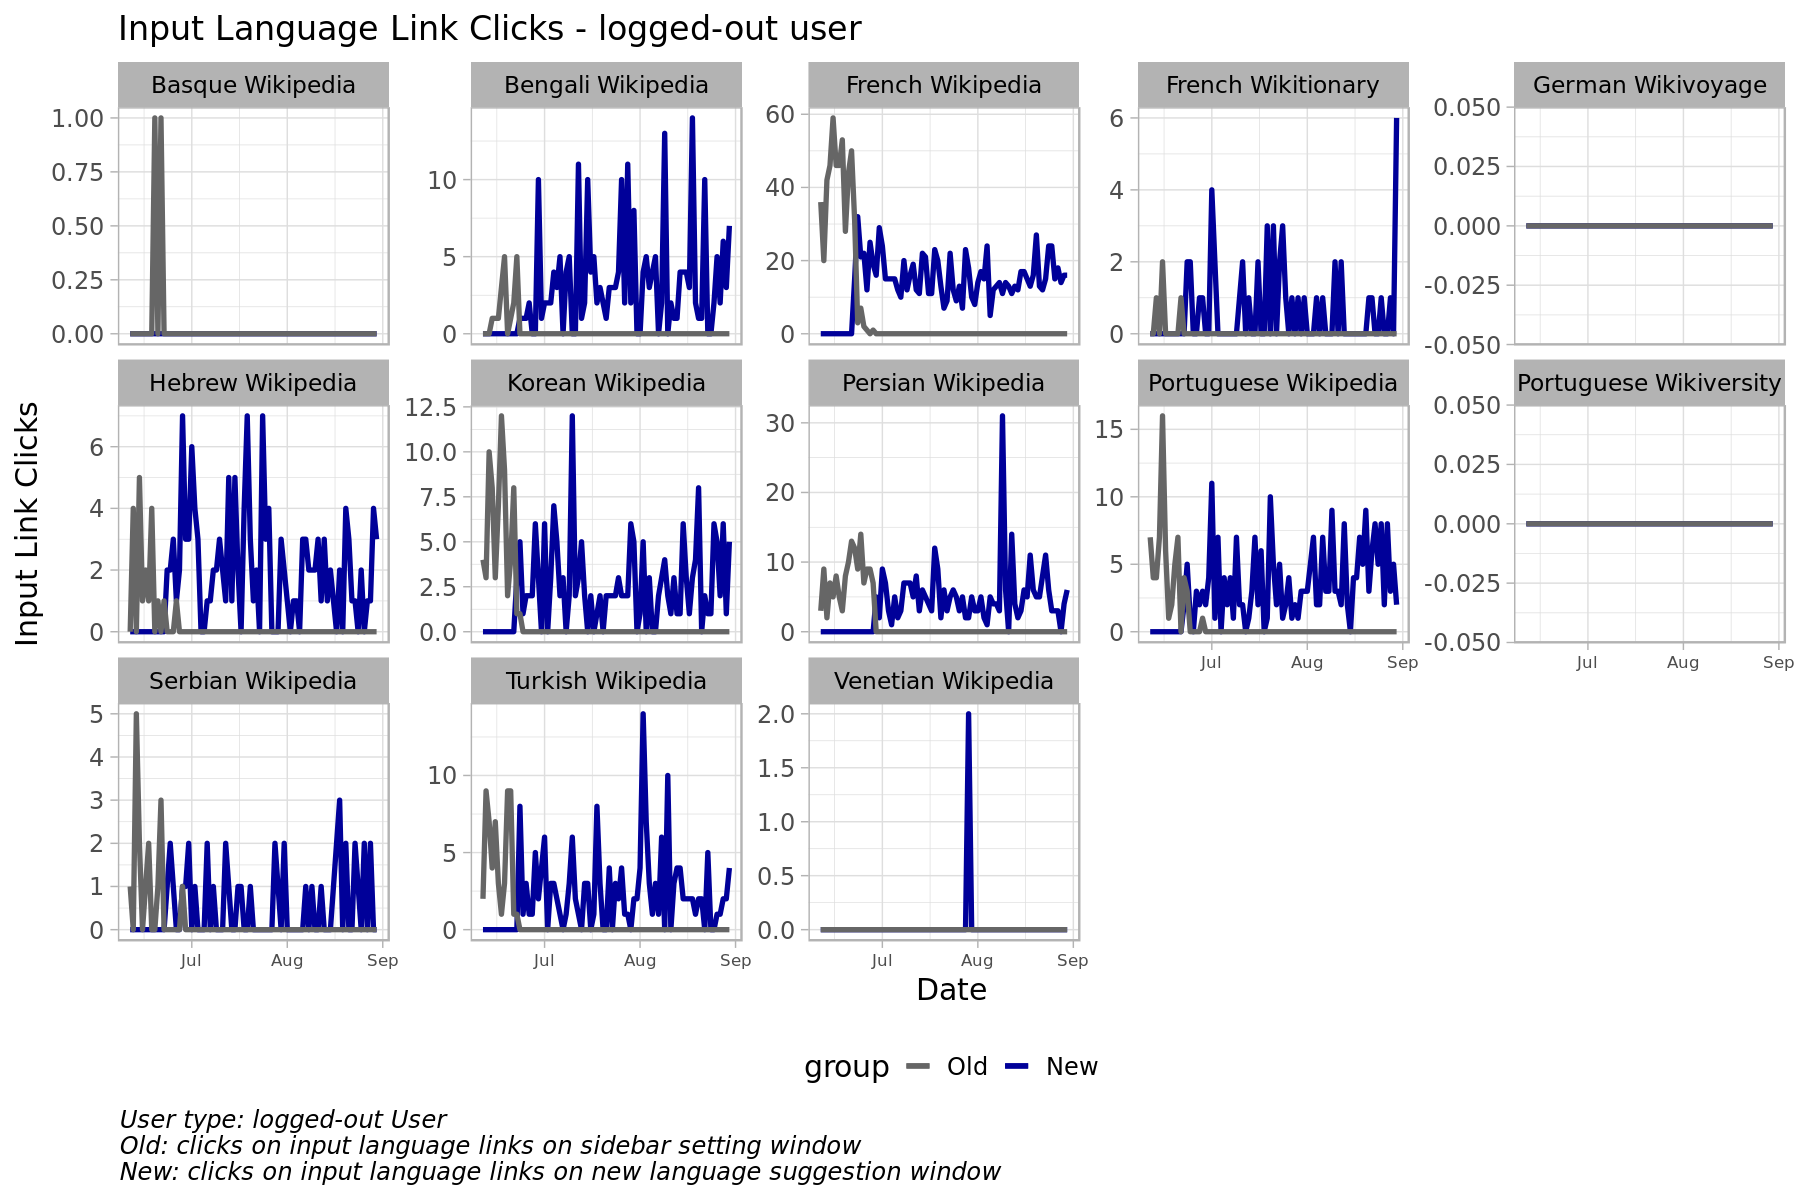

In [170]:
input_lang_click_g <- ggplot(data=filter( df_input_clicks,  (date > '2021-06-10')&(date < '2021-08-31')), 
                                mapping=aes(x=date)) +
geom_line(aes(y=new_input_language_clicks , color="c2") , size = 1.5) +
geom_line(aes(y=old_input_language_clicks, color="c1") , size = 1.5) +
facet_wrap(~wiki_name,nrow=3,scale = 'free_y')+
scale_color_manual(values= c("c1"="#666666", "c2"="#000099"), name = "group", labels = c("Old", "New"))  +
labs(title = 'Input Language Link Clicks - logged-out user',
     x = 'Date',
     y = 'Input Link Clicks',
        caption = "User type: logged-out User
Old: clicks on input language links on sidebar setting window
New: clicks on input language links on new language suggestion window") + 
theme_light(base_size = 18) +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
ggsave("Graphs_logout/input_lang.png",
    plot = input_lang_click_g , width = 60, height = 30, units = "cm", dpi = "screen");
input_lang_click_g


In [123]:
# add column classifying pre and post deployment dates
df_input_clicks_prepost <- df_input_clicks %>%
    mutate(deployment = case_when(
        date >= '2021-06-15' & date <= '2021-06-21' & wiki !='fawiki' ~ 'pre',
        date >= '2021-07-06' & date <= '2021-07-12' & wiki !='fawiki' ~ 'post',
        date >= '2021-06-21' & date <= '2021-06-27' & wiki =='fawiki' ~ 'pre',
        date >= '2021-07-12' & date <= '2021-07-18' & wiki =='fawiki' ~ 'post',        
        TRUE ~ 'NA'
    ))   %>%
    filter(deployment!='NA') %>%
    group_by(wiki_name, deployment) %>%
    summarize(old = sum(old_input_language_clicks), new = sum(new_input_language_clicks),  .groups = 'drop')

In [125]:
df_input_clicks_prepost_L <- pivot_longer(df_input_clicks_prepost, cols = c('old','new' ), names_to="group", values_to="input_lang_clicks")

In [129]:
df_input_clicks_prepost_L$deployment <- factor(df_input_clicks_prepost_L$deployment,levels = c("pre", "post"))

In [131]:

input_clicks_barchart <- df_input_clicks_prepost_L %>%
        ggplot(aes(x = deployment, y= input_lang_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(input_lang_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of input language clicks",
             title = "Number of input language clicks before and after deployment",
             caption = "User type: logged-out User
Old: clicks on input language links on setting window
New: clicks on input language links on new language suggestion window") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
           # axis.title.x=element_blank(),
           # axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

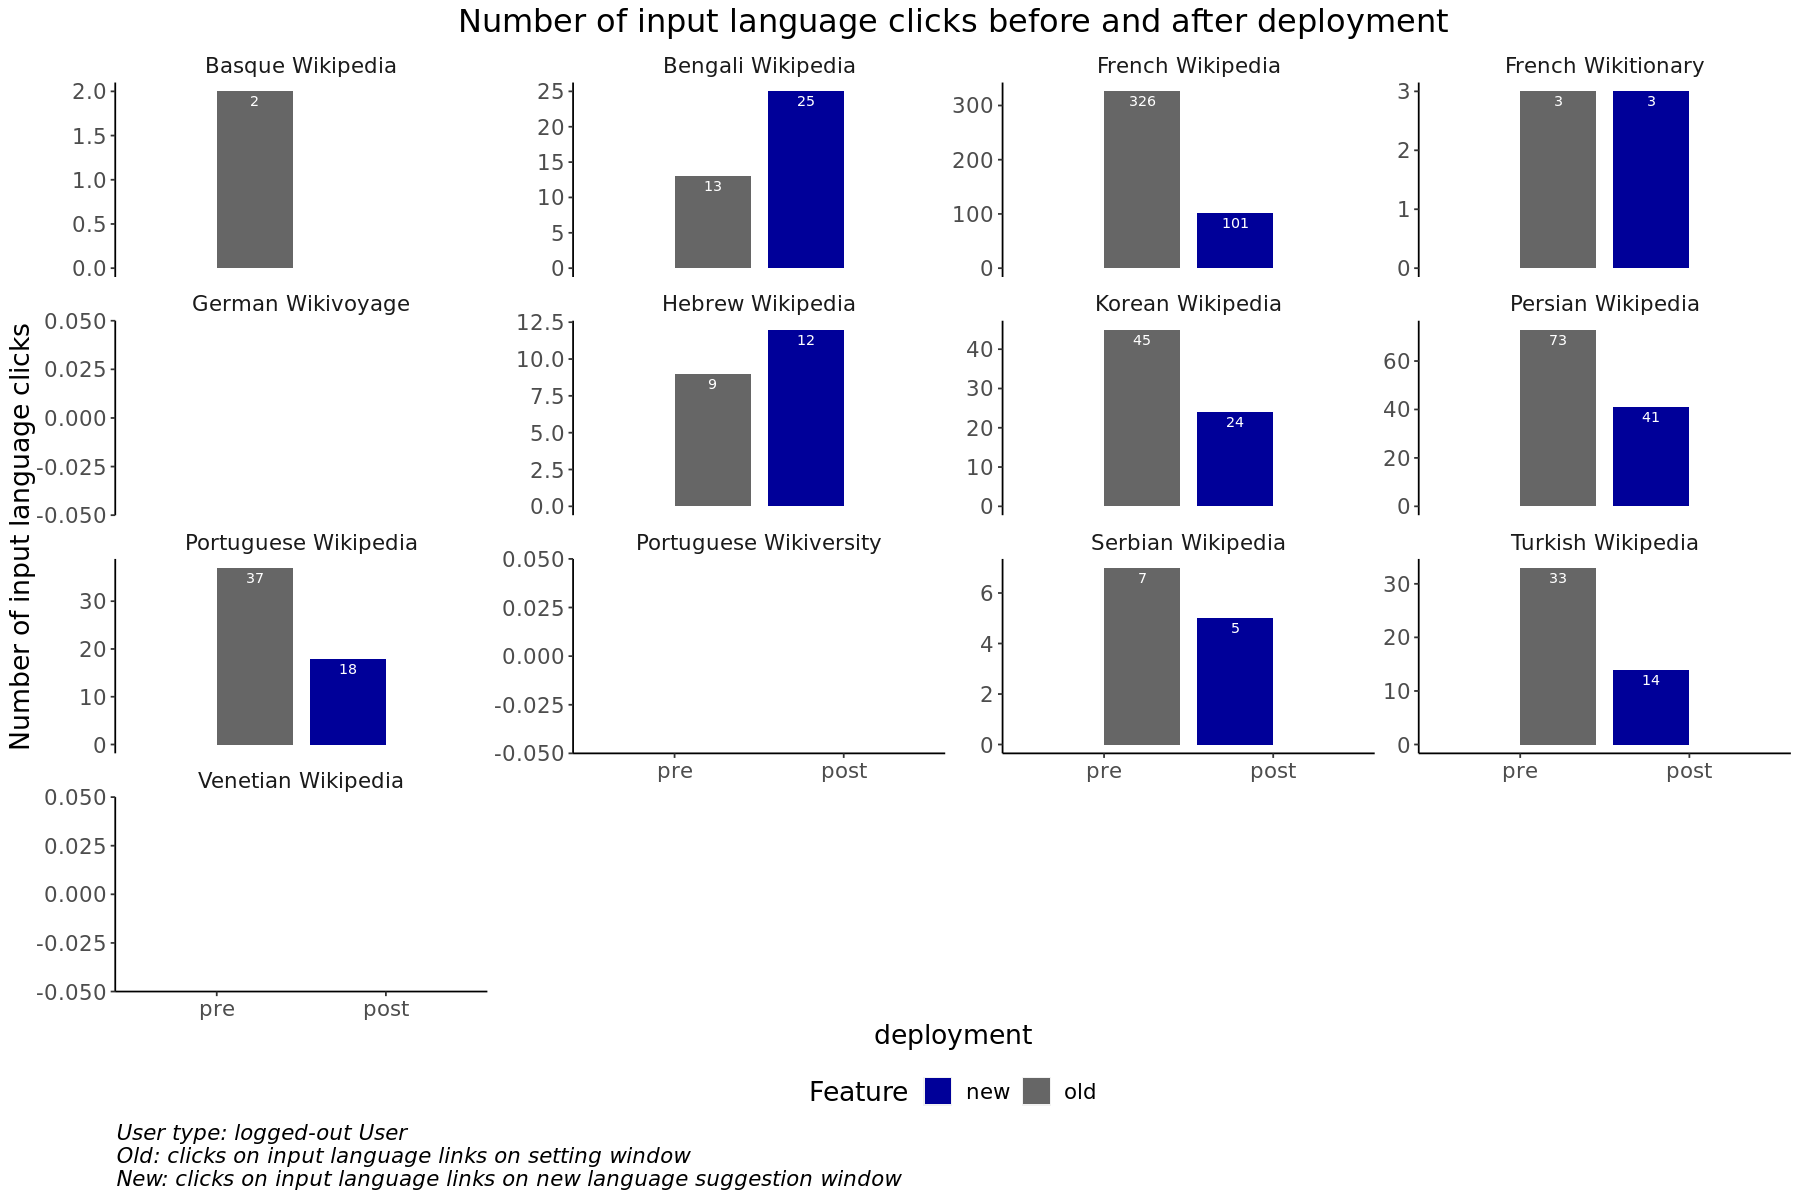

In [132]:
input_clicks_barchart

In [167]:
ggsave("Graphs_logout/input_clicks_bar.png",
    plot = input_clicks_barchart, width = 60, height = 30, units = "cm", dpi = "screen");


In [133]:
# add column for daily avg click classifying pre and post deployment dates
df_input_clicks_prepost <- df_input_clicks %>%
    mutate(deployment = case_when(
        date <= '2021-06-21' & wiki !='fawiki' ~ 'pre',
        date >= '2021-07-06' & wiki !='fawiki' ~ 'post',
        date <= '2021-06-27' & wiki =='fawiki' ~ 'pre',
        date >= '2021-07-12' & wiki =='fawiki' ~ 'post',        
        TRUE ~ 'NA'
    ))   %>%
    filter(deployment!='NA') %>%
    group_by(wiki_name, deployment) %>%
    summarize(old = mean(old_input_language_clicks), new = mean(new_input_language_clicks),  .groups = 'drop')

In [134]:
df_input_clicks_prepost_L <- pivot_longer(df_input_clicks_prepost, cols = c('old','new' ), names_to="group", values_to="daily_avg_input_lang_clicks")

In [136]:
df_input_clicks_prepost_L$deployment <- factor(df_input_clicks_prepost_L$deployment,levels = c("pre", "post"))

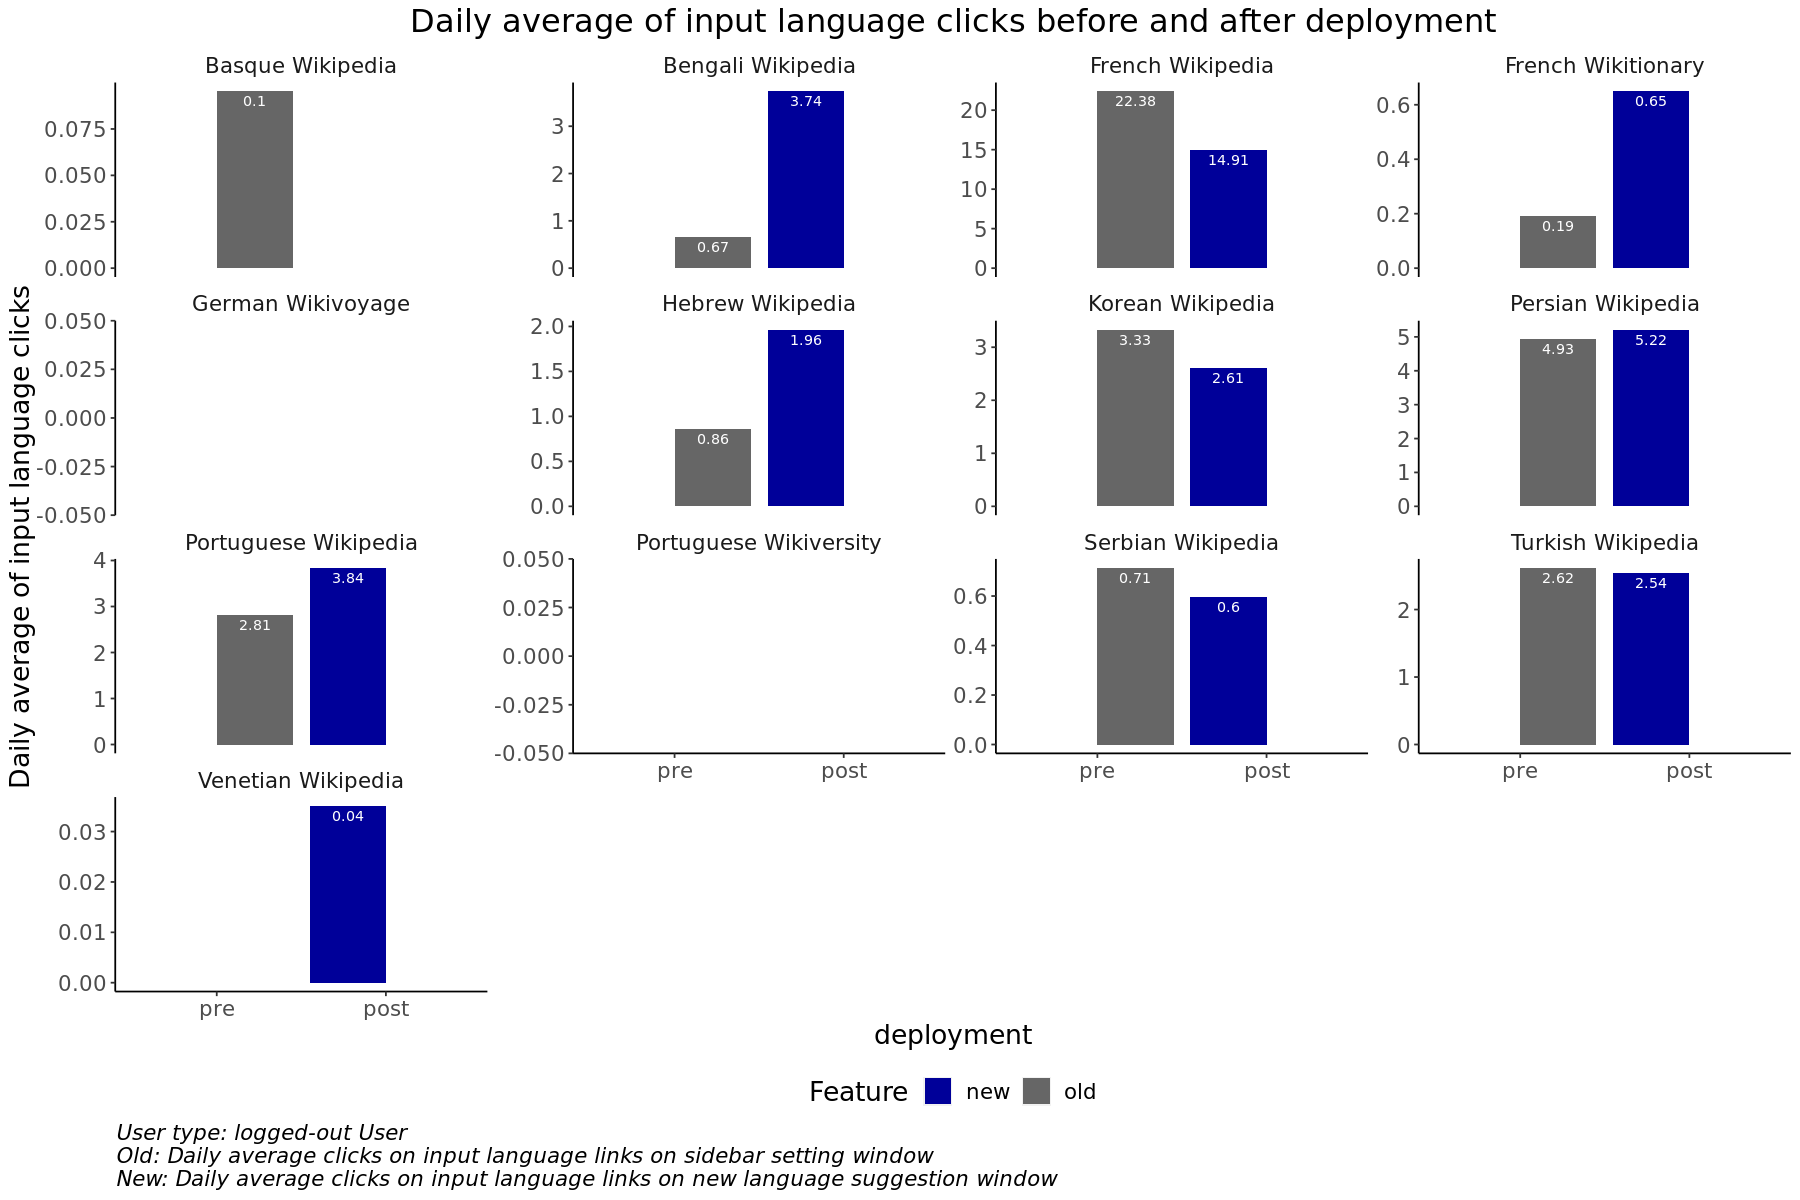

In [161]:
input_lang_barchart <- df_input_clicks_prepost_L %>%
        ggplot(aes(x = deployment, y= daily_avg_input_lang_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(round(daily_avg_input_lang_clicks,2))), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Daily average of input language clicks",
             title = "Daily average of input language clicks before and after deployment",
             caption = "User type: logged-out User
Old: Daily average clicks on input language links on sidebar setting window
New: Daily average clicks on input language links on new language suggestion window") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
input_lang_barchart 

__Determin the percentage of changes__

In [141]:
df_input_clicks_prepost$clicks <- ifelse(df_input_clicks_prepost$deployment == 'pre', df_input_clicks_prepost$old, df_input_clicks_prepost$new)

In [143]:
# determine percent change
df_input_clicks_prepost_w <- df_input_clicks_prepost %>%
  select(wiki_name, deployment,clicks) %>%
  pivot_wider(names_from = deployment, values_from = clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))


In [144]:
df_input_clicks_prepost_w

wiki_name,post,pre,pct_change
<chr>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,0.00000000,0.0952381,-100.00
Bengali Wikipedia,3.73684211,0.6666667,460.53
French Wikipedia,14.91228070,22.3809524,-33.37
French Wikitionary,0.64912281,0.1904762,240.79
German Wikivoyage,0.00000000,0.0000000,NaN
Hebrew Wikipedia,1.96491228,0.8571429,129.24
Korean Wikipedia,2.61403509,3.3333333,-21.58
Persian Wikipedia,5.21568627,4.9259259,5.88
Portuguese Wikipedia,3.84210526,2.8095238,36.75


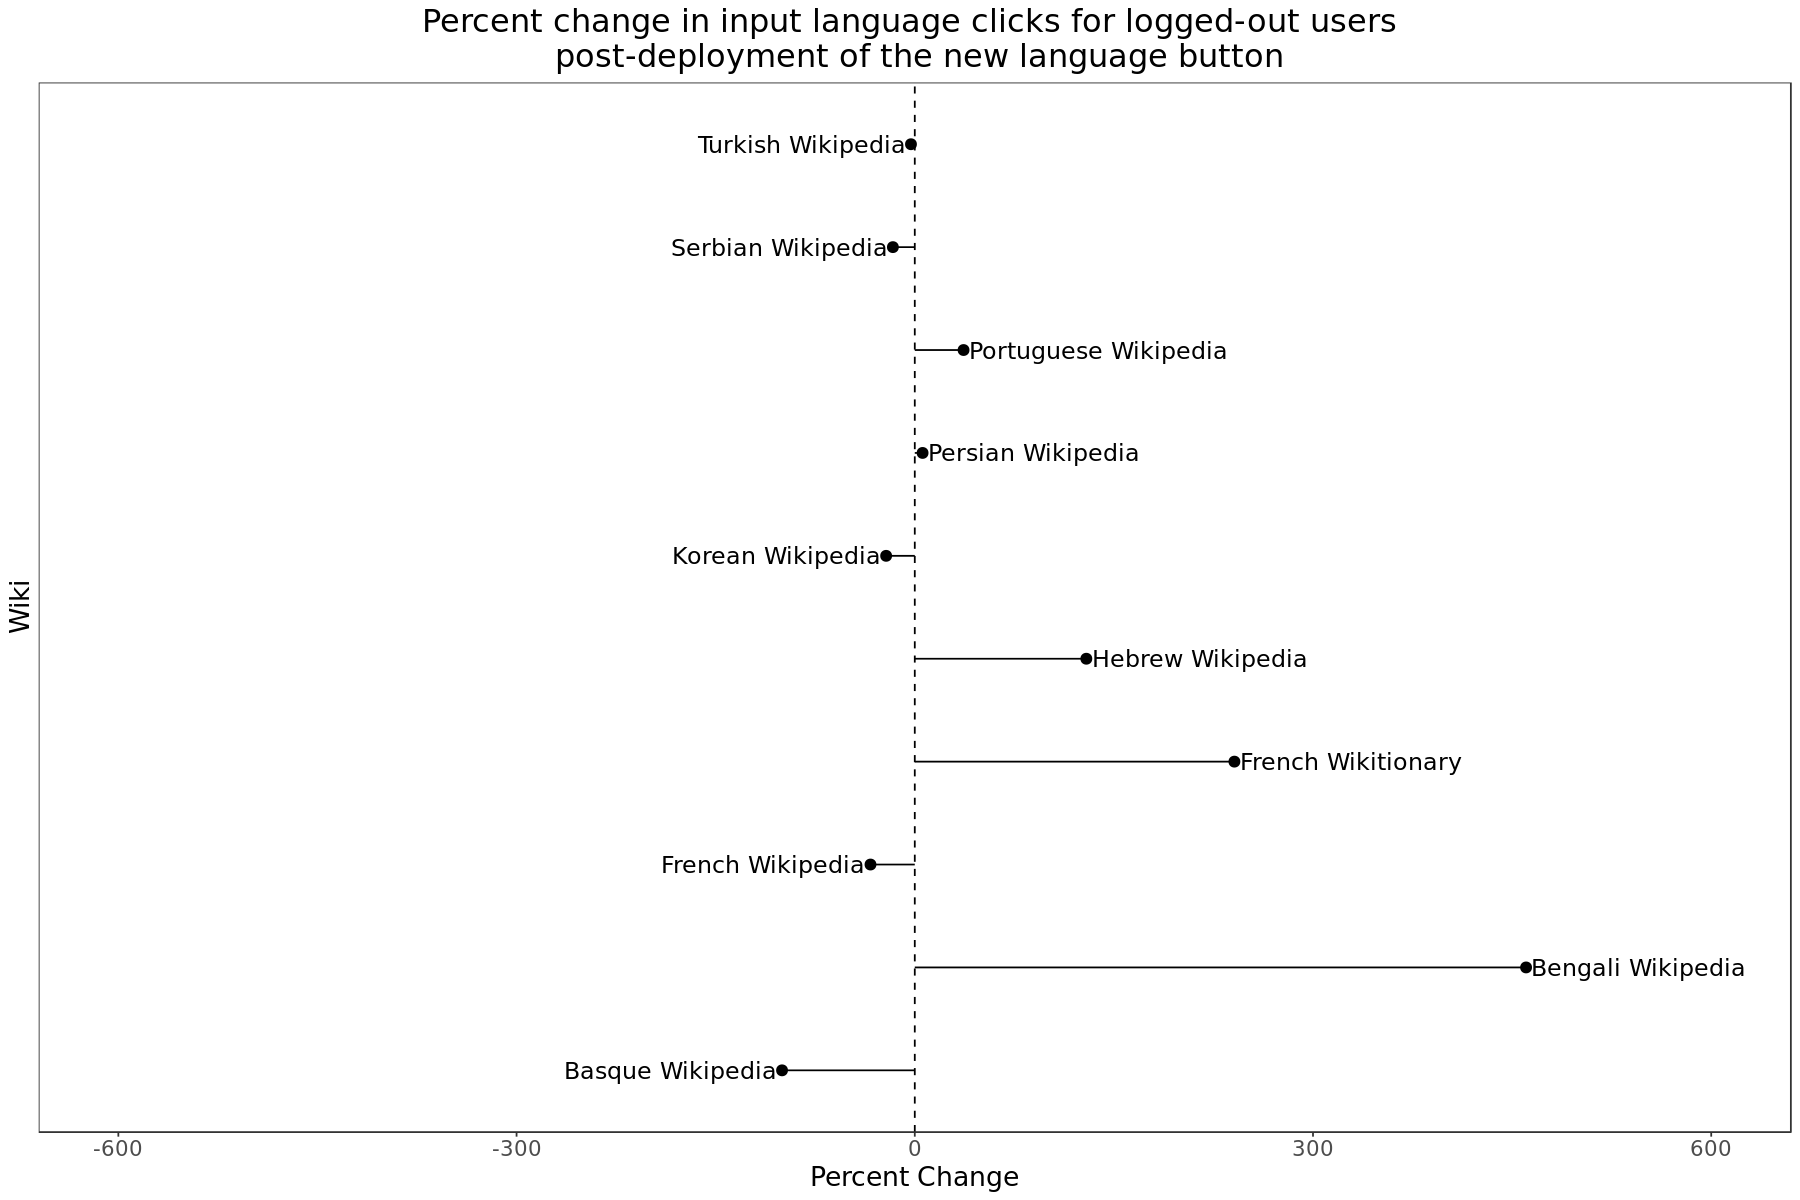

In [153]:

# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_input_g <- df_input_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in input language clicks for logged-out users \n post-deployment of the new language button") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_input_g 



In [168]:
ggsave("Graphs_logout/input_clicks_pct.png",
    plot = pct_input_g, width = 60, height = 30, units = "cm", dpi = "screen");

__Average percent change__

Average of the percent changes observed on each early adopter wiki, excluding German Wikivoyage and Venetian Wikipedia for 0 click in pre-deployment period.

In [154]:
mean((filter(df_input_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] 69.888

Average of the percent changes observed on each early adopter wiki, excluding wikis which have less than 1 in daily average clicks

In [182]:
mean(filter(df_input_clicks_prepost_w , post>=1 & pre>=1)$pct_change)

[1] -3.038

__Summary__

There was an average 69.9% decrease[^2] in daily average clicks on input language links by logged-out users on the early adopter wikis following deployment of the new language feature. The average is driven upwards mainly by Bengali Wikipedia (460.53%) and French Wiktionary (240.79%) and Hebrew Wikipedia (129.24%). They are wikis with low daily activities. If we exclude wikis which have less than 1  in daily average clicks, the average change is -3.038%. [^3]

[^2]: Calculated by taking the average of the percent changes observed on each early adopter wiki, excluding German Wikivoyage and Venetian Wikipedia for 0 click in pre-deployment period.   
[^3]: Calculated by taking the average of the percent changes observed on each early adopter wiki, excluding wikis which have less than 1 in daily average clicks.
